In [12]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from communities.algorithms import louvain_method
import time
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression, Ridge
import threading

# get correlation matrix file names
data_folder = "Data/Corr_Mat"
output_folder = "Data/Ticker_List"

## Download Data

In [13]:
def download_stock_pool_data():
    # get data directory path
    cur_path = os.path.dirname(__file__)
    data_directory_path = os.path.relpath('../Data', cur_path)

    # get latest russell 1000 constituents
    russell1000_info = pd.read_excel(
        io=data_directory_path + "\\Russell_1000_Constituents_20221007.xlsx",
        sheet_name="Holdings",
        skiprows=range(7))
    # get list of tickers
    stocks_pool_list = list(russell1000_info.Ticker.values)
    # get historical market data of current Russel 1000 constituents
    stocks_pool_data = yf.Tickers(stocks_pool_list).history(start="2012-01-01")["Close"]

    # get historical market data of S&P500
    sp500_data = pd.DataFrame(yf.Ticker("^GSPC").history(start="2012-01-01")["Close"])
    # rename S&P 500 data column
    sp500_data.columns = ["SP500"]

    # merge two dataframes
    raw_data = stocks_pool_data.join(sp500_data)

    # drop stocks with more than 1000 NaNs
    raw_data = raw_data.dropna(axis="columns", thresh=2500)

    # save stock pool data into csv
    raw_data.to_csv(data_directory_path + "\\Raw_Data_20221007.csv")

# # get stock pool data from yahoo finance
# download_stock_pool_data()

## Generate Correlation Matrices

In [14]:
def generate_residual_matrices():
    # get data directory path
    cur_path = os.path.dirname(__file__)
    data_directory_path = os.path.relpath('../Data', cur_path)
    # read data from file
    raw_data = pd.read_csv(data_directory_path + "\\Raw_Data_20221007.csv", index_col=0)

    # set rebalancing frequency: every month
    rebalance_freq_period = relativedelta(months=1)
    # set business day convention for rebalancing
    business_day_convention = "Modified Following"
    # training set length
    train_set_length_period = relativedelta(months=6)
    # set date range
    first_date = datetime.strptime(raw_data.index[0], "%Y-%m-%d")
    last_date = datetime.strptime(raw_data.index[-1], "%Y-%m-%d")

    # initialize date range
    train_start_date = first_date
    train_end_date = train_start_date + train_set_length_period - relativedelta(days=1)

    test_start_date = train_end_date + relativedelta(days=1)
    test_end_date = test_start_date + rebalance_freq_period

    # traverse the data set
    while test_end_date < last_date:
        # do regression
        temp_train_data = raw_data.loc[train_start_date.__str__()[:10]:test_start_date.__str__()[:10], :]
        # save the residuals
        temp_residuals = pd.DataFrame(index=temp_train_data.index, columns=temp_train_data.columns.drop("SP500"))
        for ticker in temp_residuals.columns:
            # get data
            y_x = temp_train_data[[ticker, "SP500"]]
            # drop nas
            y_x = y_x.dropna(axis="index", how="any")
            # rename columns
            y_x.columns = ["y", "x"]
            # whether there's sufficient trading days
            if len(y_x.index) < len(temp_train_data) * 0.9:
                continue
            else:
                # calculate returns
                y_x = np.log(y_x).diff().dropna(axis="index", how="any")
                y = np.array(y_x["y"])
                x = np.array(y_x["x"]).reshape(-1, 1)
                # do regression
                reg = LinearRegression(fit_intercept=True).fit(x, y)
                # calculate residual
                y_x.loc[:, "res"] = np.subtract(y, (reg.intercept_ - reg.coef_[0] * x)[:, 0])
                # add residual to temp_residuals
                temp_residuals.loc[y_x.index, ticker] = y_x.res
        # drop nans in dataframe
        temp_residuals = temp_residuals.dropna(axis="index", how="all")
        temp_residuals = temp_residuals.dropna(axis="columns", how="any")
        # calculate correlations
        temp_residuals = temp_residuals.astype(float)
        temp_corr_matrix = temp_residuals.corr()

        # save the matrix to file
        temp_corr_matrix.to_csv(data_directory_path + "\\Corr_Mat\\" + train_start_date.__str__()[:10] + ".csv")

        # update dates
        train_start_date += rebalance_freq_period
        test_start_date += rebalance_freq_period
        test_end_date += rebalance_freq_period

# # calculate correlation between residuals of stocks during 6M period
# generate_residual_matrices()

## Split Graph Into Communities

In [15]:
def get_communities(file_name:str, input_folder:str = data_folder):
    print(file_name)
    # get correlation matrix
    corr_mat = pd.read_csv(input_folder+"/"+file_name, index_col=0)
    # convert to adjacency matrix
    adj_mat = np.abs(corr_mat - np.diag(np.diag(corr_mat)))
    # using Louvain method to split the graph into 20 communities
    communities, _ = louvain_method(adj_mat.values, 20)
    # get ticker list of each community
    cluster_list = []
    for community in communities:
        cluster = list(community)
        cluster_list.append(adj_mat.columns[cluster])
    # save the list to txt
    global output_folder
    with open(output_folder + "/"+file_name.replace(".csv",".txt"), 'w') as f:
        for cluster in cluster_list:
            f.write(str(list(cluster)) + "\n")

In [16]:
class MyThread(threading.Thread):

    def __init__(self, func, arg):
        super().__init__()
        self.func = func
        self.arg = arg

    def run(self):
        self.func(*self.arg)

In [17]:
def get_all_communities(file_list:list[str] = os.listdir(data_folder), input_folder:str = data_folder, thread_num:int = 8):
    # create 8 threads
    for i in range(0, len(file_list), thread_num):
        thread_list = []
        print("Iteration {} start, current time = {}".format(i//8+1, datetime.now()))
        for j in range(thread_num):
            file_name = file_list[i + j]
            thread = MyThread(get_communities, (file_name, input_folder))
            thread.start()
            thread_list.append(thread)
        for thread in thread_list:
            thread.join()

# generate clusters of tickers and save them to txt file
# file_name_list = os.listdir(data_folder)
# get_all_communities(file_name_list, data_folder, 8)

## Get Centroids of Clusters

In [18]:
def unwrap_list_from_str(str_list:str)->list[str]:
    return str_list.replace("\'","").replace("[","").replace("]","").replace("\n","").replace(" ", "").split(",")

def get_tickers_of_clusters():
    # read clusters from file
    file_name_list =os.listdir(output_folder)
    df_cluster_data = pd.DataFrame(columns=["cluster_{}".format(i) for i in range(20)])
    for file_name in file_name_list:
        # read string from file
        with open(output_folder+"/"+file_name, "r") as f:
            list_str_data = f.readlines()
        list_data = []
        for str_data in list_str_data:
            list_data.append(unwrap_list_from_str(str_data))
        df_cluster_data.loc[file_name[:10],:] = list_data
    return df_cluster_data

# # save clusters as a dataframe
# df_cluster_data = get_tickers_of_clusters()
# # save to local
# df_cluster_data.to_csv("Data/Stock_Clusters.csv")

In [19]:
def stock_selection(df_cluster_info:pd.DataFrame)->pd.DataFrame:
    # naive selection: choose first stock of each cluster
    df_selected = pd.DataFrame(columns=df_cluster_info.columns, index=df_cluster_info.index)
    for idx in df_selected.index:
        # get corresponding correlation matrix
        corr_mat = pd.read_csv(data_folder+"/"+idx+".csv",index_col=0)
        for col in df_selected.columns:
            cluster_stock_list = df_cluster_info.loc[idx, col]
            temp_corr_mat = corr_mat.loc[cluster_stock_list, cluster_stock_list]
            selected = cluster_stock_list[np.mean(temp_corr_mat).argmax()]
            df_selected.loc[idx,col]= selected
    return df_selected

def select_stock_from_clusters()->(pd.DataFrame,pd.DataFrame):
    # read data from local
    df_cluster_data = pd.read_csv("Data/Stock_Clusters.csv",index_col=0)
    # convert string to list
    df_cluster_data = df_cluster_data.applymap(lambda x: unwrap_list_from_str(x))

    # read stock price data from locals
    performance_data = pd.read_csv("Data/Raw_Data_20221007.csv", index_col=0)

    # select stocks from clusters
    df_selected = stock_selection(df_cluster_data)

    # get weights of constituents
    df_coef = pd.DataFrame(columns=df_selected.columns, index=df_selected.index)
    for idx in df_selected.index:
        stock_list = list(df_selected.loc[idx,:].values)
        end = str(datetime.strptime(idx, "%Y-%m-%d") + relativedelta(months=6))[:10]
        df_x = np.log(performance_data.loc[idx:end,stock_list]).diff().dropna()
        df_y = np.log(performance_data.loc[idx:end,["SP500"]]).diff().dropna()

        # regress to get optimal weights using Ridge regression
        model =LinearRegression(fit_intercept=False, positive=True)
        model.fit(df_x.values, df_y.values)
        df_coef.loc[idx,:] = model.coef_[0]

    # reset index of two dfs
    df_coef.index = df_coef.index.map(lambda x: str(datetime.strptime(x, "%Y-%m-%d") + relativedelta(months=6))[:10])
    df_selected.index = df_selected.index.map(lambda x: str(datetime.strptime(x, "%Y-%m-%d") + relativedelta(months=6))[:10])

    return df_coef, df_selected

# get coefficients of each constituent
df_coef, df_selected = select_stock_from_clusters()

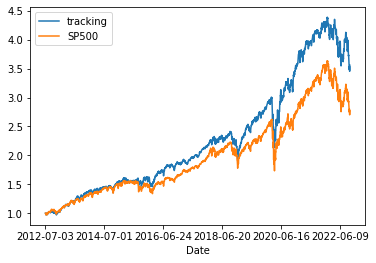

In [20]:
def traking_record(df_coef:pd.DataFrame, df_selected:pd.DataFrame):
    # read stock price data from locals
    performance_data = pd.read_csv("Data/Raw_Data_20221007.csv", index_col=0)
    # track performance of our portfolio
    list_df_record = []
    for idx in range(len(df_coef.index)):
        start = df_coef.index[idx]
        if idx < len(df_coef.index)-1:
            end = df_coef.index[idx+1]
        else:
            end = "2022-10-03"
        # get stock list
        stock_list = list(df_selected.iloc[idx,:].values)
        # get coefficients
        coef_list = list(df_coef.iloc[idx,:].values) + [1 - sum(df_coef.iloc[idx,:].values)]
        # performance of this month
        temp_performance = performance_data.loc[start:end,stock_list].copy()
        # set initial value as 1
        temp_performance.loc[:,:] /= temp_performance.iloc[0,:]
        # calculate portfolio return
        temp_df_record = pd.DataFrame(index=temp_performance.index, columns=["tracking", "SP500"])
        temp_df_record.loc[temp_performance.index,["tracking"]] = temp_performance.apply(lambda x: np.dot(coef_list[:-1],x)+coef_list[-1], axis=1)
        # calculate SP500 return
        temp_benchmark = performance_data.loc[start:end,["SP500"]].copy()
        temp_benchmark.loc[:,:] /= temp_benchmark.iloc[0,:]
        temp_df_record.loc[temp_benchmark.index, ["SP500"]] = temp_benchmark["SP500"]
        list_df_record.append(temp_df_record.dropna(how="any"))

    # concat all the dataframes
    df_record = pd.DataFrame(index=performance_data.index, columns=["tracking","SP500"])
    init = [1,1]
    for ele in list_df_record:
        ele *= init
        df_record.loc[ele.index, ele.columns] = ele.values
        init = list(ele.iloc[-1,:].values)
    # dropna
    df_record = df_record.dropna()
    df_record.plot()
    plt.savefig("Data/Result.png")
    df_record.to_csv("Data/Result.csv")

    return  df_record

df_record = traking_record(df_coef, df_selected)

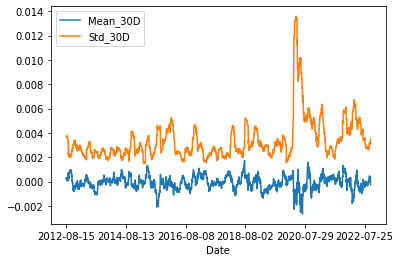

In [21]:
def calc_tracking_error():
    # read data fromlocal
    df_result = pd.read_csv("Data/Result.csv",index_col=0)
    # calculate log return
    df_result = np.log(df_result).diff().dropna()
    df_result["diff"] = df_result.SP500 - df_result.tracking
    # print 30-day rolling mean and std of the tracking error
    df_stats = pd.DataFrame(index=df_result.index)
    df_stats.loc[:,"Mean_30D"] = df_result["diff"].rolling(30).mean()
    df_stats.loc[:,"Std_30D"] = df_result[["diff"]].rolling(30).std()
    # drop nas
    df_stats = df_stats.dropna()
    df_stats.plot()
    plt.savefig("RollingDeviation.png")
    df_stats.to_csv("Data/Result_Stats.csv")

calc_tracking_error()

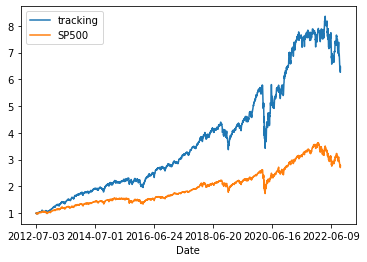

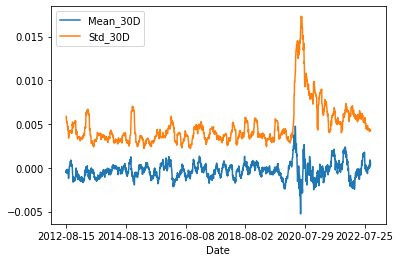

In [22]:
df_coef.loc[:,:] = 0.05
df_record = traking_record(df_coef, df_selected)
calc_tracking_error()